<a href="https://colab.research.google.com/github/ShynPham/pytorch_learning_journey/blob/main/09_Pytorch_Model_Developement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

So far, what we have done is considered only "back-end" of an app. Then how do we make it "front-end" as well? In this final part, we will be deploying our FoodVision Mini model to the internet as a usuable app

# So what and why deploy a machine learning model?

Machine learning model deployment is the process of making your machine learning model acccessible to someone or something else?

The purposed of this is so people(consumers) or another machine learning developer could improves as we go.

There are lots of example of mix/match deployment in real life and we can achieve all of these by using and improving everyday.

**So why deploy?**

Deploying a model is one of the most important part, it can get us a idea of how good our model's is to other datasets out there on the internet.


Different type of machine learning model deployment.

You can find more about that in https://www.learnpytorch.io/pytorch_extra_resources/

# 0. getting setup
As we done previously, let's make sure all of the modules we need is import for this section, and if we forgot any, we will import along the way.

In [ ]:
# Check the torch version and torchvision version
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [ ]:
# Continue with regular import and get torchinfo install if not install

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
# Download the going_modular directory from github
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # Get the going_modular srcipts
  print(f"[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from github")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from github
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 22.25 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [ ]:
# Finally setup device agnostic code to make sure it is run on GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Getting data

We will be using 20% of the dataset on pizza_steak_sushi from Food101.

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup training and testing dir
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

# 2. Model deployment outline

Before we jump into coding, let's summary what we need and what our goals is:

The idea is to deployed a FoodVision Mini model that perform well and fast, to be precise: with 95% acc and 30FPS(this is how much human eyes can progress)

So our goal is:

1. Performance: A model that perform with 95% accuracy
2. Speed: A model that can classify images at ~30FPS(0.03 sections inference time per images)

To achieve the result above, we need the best performing model and from pervious sections we known that:

1. EffNtB2 feature extractor(EffNetB2 for short) is the best performing model that have been test previously with adjusted `classifer` layer
2. ViT-B/16 extractor feature(ViT for short) - is the best custome performing model that have been test previously with adjusted `head` layer

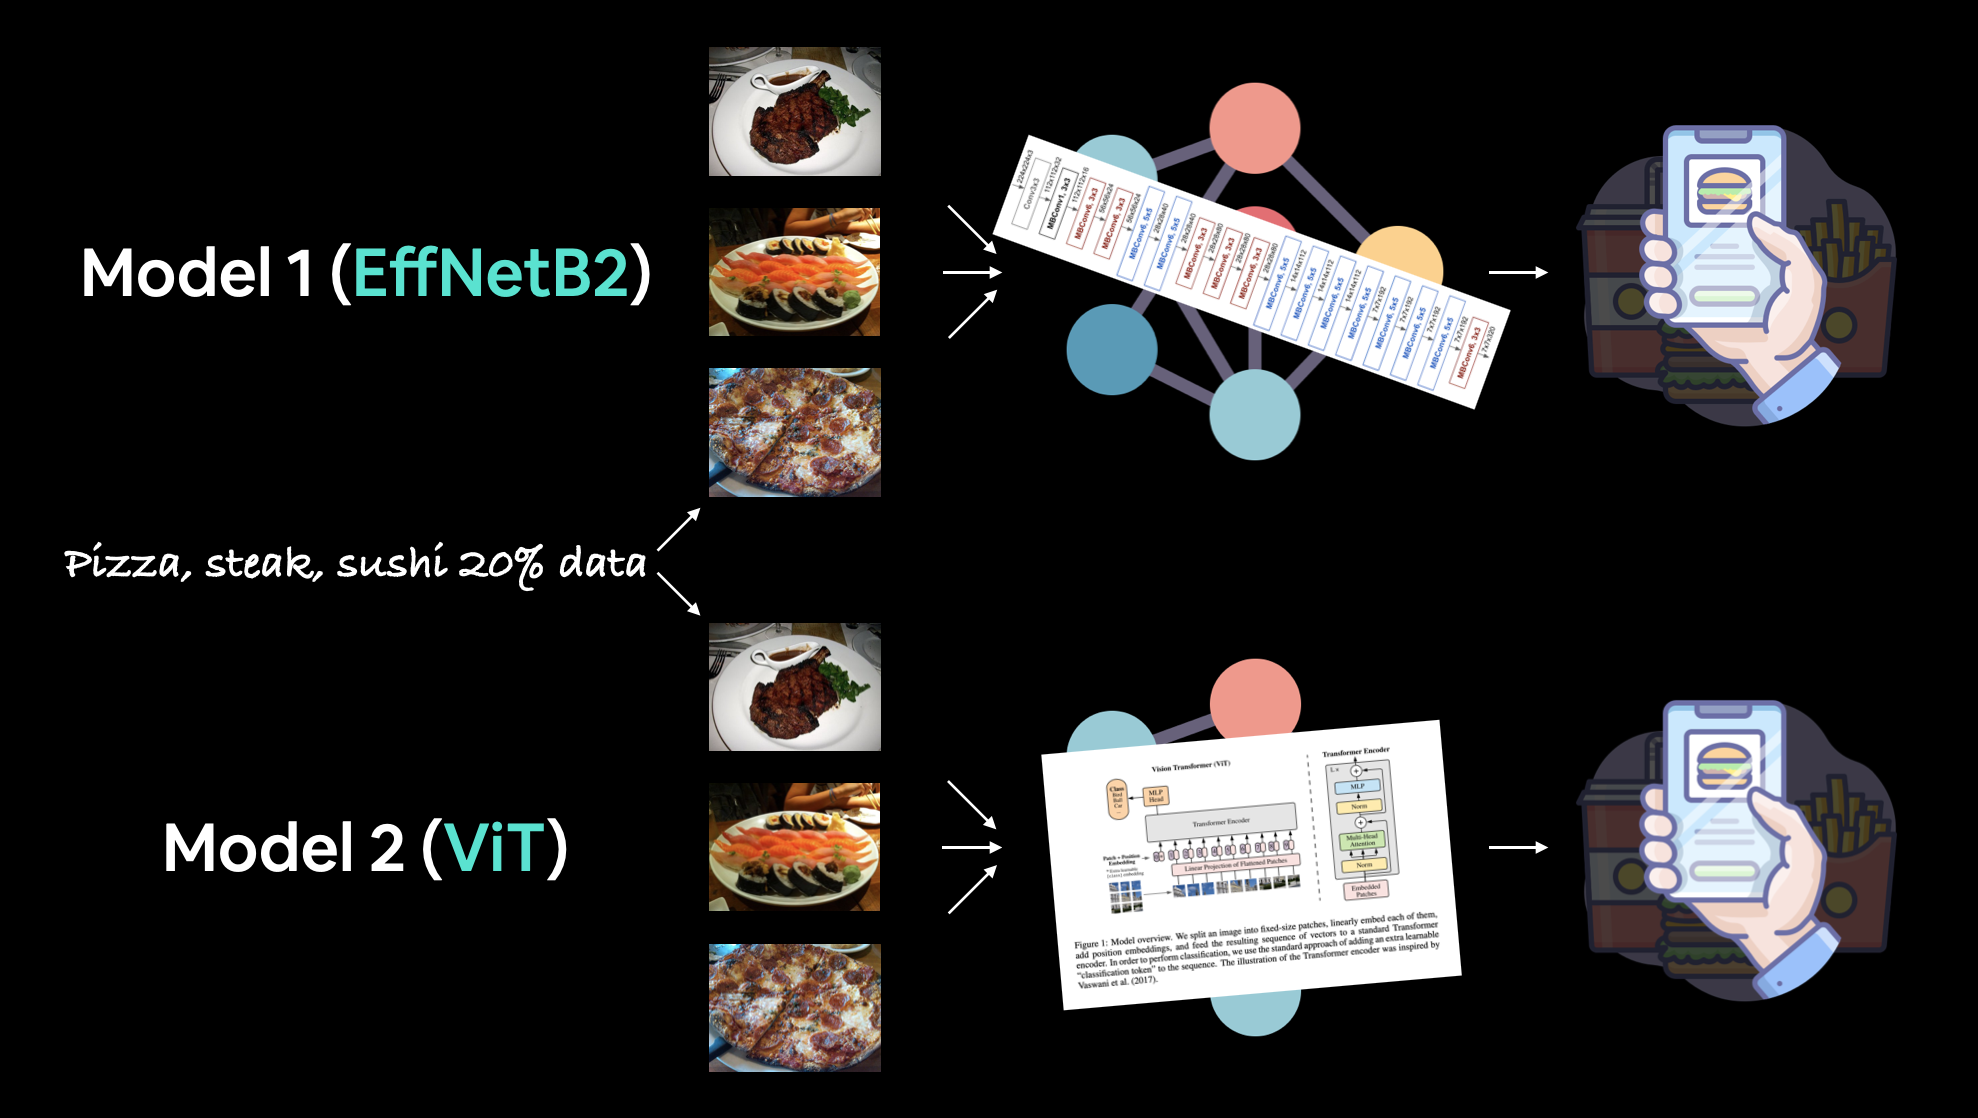
img source: [learnpytorch.io](https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data)

# 3. Creating an EffNetB2 extractor features

Let's recreate the results that we've done before, and to do that we will need:

1. Setup the pretrained weight as `weight=torchvision.models.EfficientNet_B2_Weights.DEFAULT`, where `"DEFAULT"` mean "best currently available"
2. get the pretrained model images transforms from the weights with the `transforms()`
3. Create a pretrained model instance by passing the weight to an instance of `torchvision.models.efficientnet_b2`
4. Freeze the base layers in the model
5. Update the classififer head to suits our own data.

In [ ]:
# 1. Setup the pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Setup the transforms
effnetb2_transforms = effnetb2_weights.transforms()
# 3. Setup a pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

# 4. Freeze the base layers in the model
for param in effnetb2.features.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 170MB/s]


Now the last step is to change the classifier head to suits our own need, to do it first we need to check the `classifer` attribute of our model.


In [ ]:
# check our EffNetb2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# 5. Update the classifier head to suit our need
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3))

## 3.1 Creating an EffB2Net feature extractor
Let's make a function of our EffNetb2 extractor so we can use it later on

Lt's call it `create_effnetb2_model()` and it take customizable classes and a random seed for productivity

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Now let's check it out


In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [ ]:
# Check out the summary
from torchinfo import summary
summary(effnetb2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 3.2 Creating DataLoader for EffNetB2
We got our feature extractor ready, so now we need `DataLoader`'s

We can do this by using `data_setup.create_dataloaders()` funciton we just import

We'll be using a `batch_size` of 32 and transform our images using `effnetb2__transforms` so they're in the same format that our `effnet2` models was trained on.

In [ ]:
#setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

## 3.3 Training EffNetB2 feature extractor

Model ready, DataLoader ready, now let's train!


We will be using 10 epochs with the Adam optimizer and learning rate of `1e-3` and we will be nn.CrossEntropyLoss for the loss function because of multi-class classificiation.

We also will be using engine.py script to trained from going_modular

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# setup seed
set_seeds()
#train model
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


Great now we will inspect it visualy.

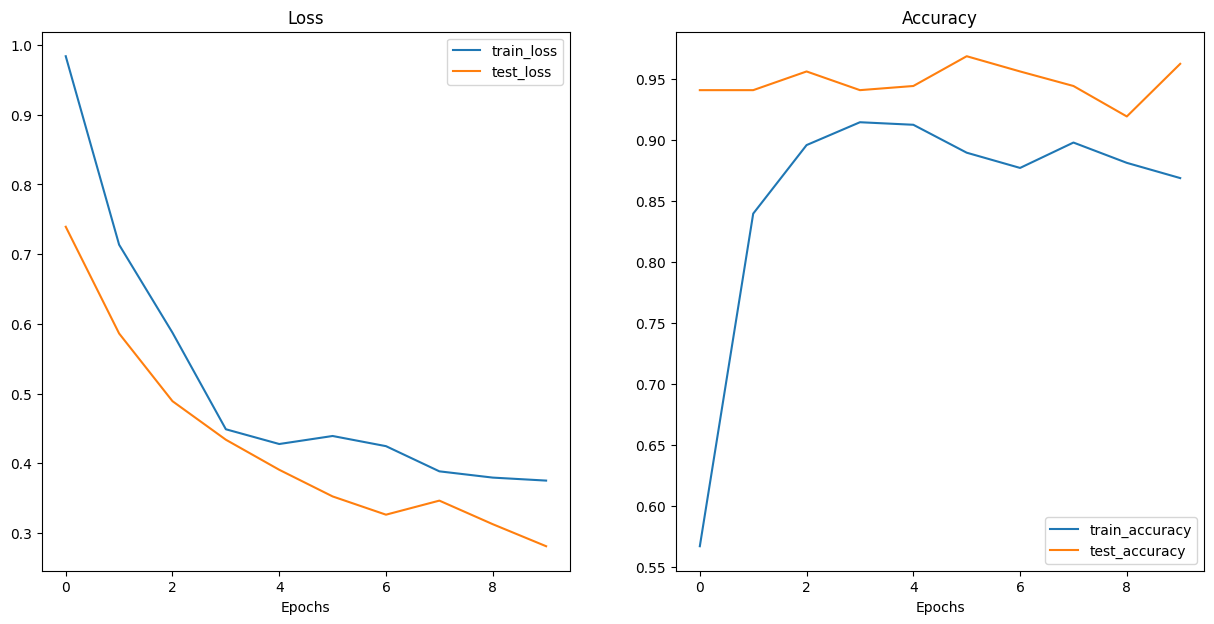

In [ ]:
## 3.4 Plot EffNetB2 loss curve
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)
#

## 3.5 Saving EffNetB2 feature extractor
Not bad, now we gonna save the models for future use



In [ ]:
## 3.5 Saving EffNetB2 feature extractor
from going_modular.going_modular import utils
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor.pth


## 3.6 Checking the size
Last step is to check everthing.


In [ ]:
from pathlib import Path
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor.pth").stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 features extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 features extractor model size: 29 MB


## 3.7 Collecting EffNetB2 feature extractor stats

We've got a few statstic about our EFfNetB2 features extractor model such as test loss and test ac and model size. Now, we'll collect them all in a dictionary so we can compare them to the upcoming ViT feature etractor

And calculated an extra one, total number of parameters

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
print(f"Total number of parameters in EffNetB2: {effnetb2_total_params}")

Total number of parameters in EffNetB2: 7705221


Put everything into a dictionary so we can make comparision later on_off

In [ ]:
# Create a dictionary with EffNEtB2 stattistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "model_size (MB)": pretrained_effnetb2_model_size,
                  "number_of_parameters": effnetb2_total_params}
effnetb2_stats

{'test_loss': 0.2810868382453918,
 'test_acc': 0.9625,
 'model_size (MB)': 29,
 'number_of_parameters': 7705221}

# 4. Creating a ViT extractor features
We have create EffNetB2 feature extractor

Now we will work on ViT

It is also the same progress and the only difference is that `torchvision.models.vit_b_16` output layers is called heads rather than classifier



In [ ]:
# Check out ViT Head layers
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  """
  Creates a ViT feature extractor model and transforms.
  Args:
    num_classes (int, optional): number of classes in the classifier head.
      Defaults to 3.
    seed (int, optional): random seed value. Defaults to 42.
  Returns:
    model (torch.nn.Module): ViT feature extractor model.
    transforms (torchvision.transforms): ViT image transforms.
  """
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze the layer
  for param in model.parameters():
    param.requires_grad=False
  # Set seed
  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768,
                                        out_features=num_classes))
  return model, transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transform = create_vit_model(num_classes=3,
                                      seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 124MB/s]


In [ ]:
from torchinfo import summary
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## 4.1 Setup dataloader for ViT



In [ ]:
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                      test_dir=test_dir,
                                                                                      transform=vit_transform,
                                                                                      batch_size=32)

## 4.2 training ViT feature extracotr
Training time!

We'll be using engine.py just like the last time to help us with trianing

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer =  torch.optim.Adam(params=vit.parameters(),
                              lr=1e-3)
# setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# setup seeds
set_seeds()
# train
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


## 4.3 INspecting Vit loss curvev

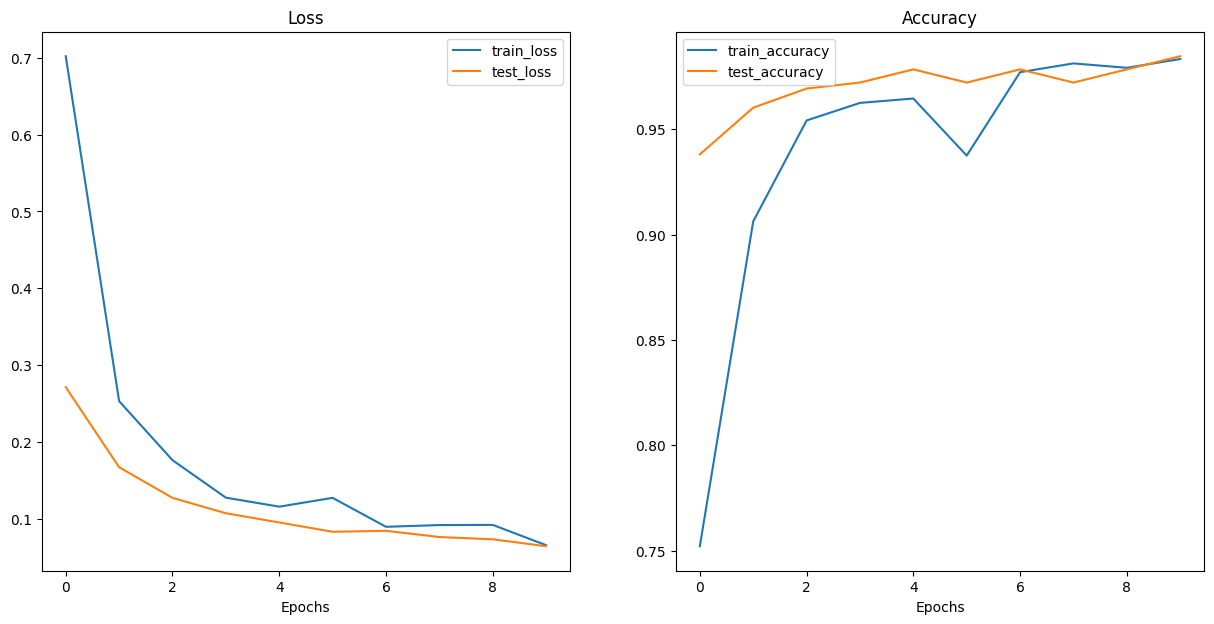

In [ ]:
plot_loss_curves(vit_results)

## 4.4 saving the model


In [ ]:
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor.pth


In [ ]:
## 4.5 Checking size of the ViT
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT features extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT features extractor model size: 327 MB


## 4.6 Collecting stats

In [ ]:
\
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

# 5. Making predictions with our trained models and timing then

We got our trained models, both performing really well.


Now we gonna go an trained them!

We got both models that perform >95% accuracy, but how fast can they be?

Ideally, we need it to be as fast as our i can see(30FPS).

**Now into our second criteria: a fast model.**

We will create a function to find out how long each of our models take to perform, we will called it `pred_and_store()`

We'll use a set of iamges as a test set and Python `pathlib.Path("target_dir).glob("/".jpg))`

In [ ]:
from pathlib import Path

print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_path = list(Path(test_dir).glob("*/*.jpg"))
test_data_path[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1082384.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/550687.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/108310.jpg')]

## 5.1 Creating a function to make predicitions across the datasets
Let's get to work on our `pred_and_store()` function:

1. Create a function that list f path, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device
2. Create an empty list to store prediction dictionaries (we want the funcction to retun a list of dictionaries, one for each prediction).
3. Looop through the target input paths(steps 4-14 will happen inside the loop)
4. Create an empty dicitionary for each iteration in the loop to store prediction values per samples.
5. Get the sample path and ground truth class name( we can do this by inferring the class from the path)
6. Start the prediction using Python timer `timeit.default.time()`.
7. Open the image using `PIL.Image.open(path)`
8. Tarnsform the image to it's capable of being used with the target model as well as add a batch dimension and sed the image to target device.
9. Prepare the model for infeternce by sending it to the target device and putting into `eval()`mode
10. Turn on `torch.inference_mode()` and pass the taget transformed image to the model and calculated the prediction probabilities using `torch.softmax()` and the target label using `torch.argmax()`
11. Add the predcition probability and prediction class to the prediciton dict created in step 4. Make sure the prediction is on the CPU so we can use Numpy and padas for later inspectiion
12. End the prediction timer started tin step 6 and add the time to the prediction dictionary
13. See if the predicted class matches the ground class from step 5 and add the results to the prediciton dictionary
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. Return the list of prediction dictionaries


In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaries
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

## 5.2 Making and timing predictions with EffNetB2

and now we use `pred_and_store()` funciton!

In [ ]:
effnetb2_test_pred_dicts =  pred_and_store(paths=test_data_path,
                                           model=effnetb2,
                                           transform=effnetb2_transforms,
                                           class_names=class_names,
                                           device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# INspect the prediction dict
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1082384.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.62,
  'pred_class': 'steak',
  'time_for_pred': 0.345,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9345,
  'pred_class': 'steak',
  'time_for_pred': 0.1136,
  'correct': True}]

In [ ]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6200,steak,0.3450,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9345,steak,0.1136,True
2,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.8644,steak,0.1090,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.8698,steak,0.1081,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8480,steak,0.1342,True


In [ ]:
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


In [ ]:
# Ffind the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1138 seconds


In [ ]:
effnetb2_stats["time_per_pred"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2810868382453918,
 'test_acc': 0.9625,
 'model_size (MB)': 29,
 'number_of_parameters': 7705221,
 'time_per_pred': np.float64(0.1138)}

## 5.3 Making and timing predictio with VIT

In [ ]:
vit_test_pred_dicts = pred_and_store(paths=test_data_path,
                                     model=vit,
                                     transform=vit_transform,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Check the first 2  prediciton
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1082384.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9931,
  'pred_class': 'steak',
  'time_for_pred': 0.7226,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9978,
  'pred_class': 'steak',
  'time_for_pred': 0.5451,
  'correct': True}]

In [ ]:
# Turn prediction into DF frame
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9931,steak,0.7226,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9978,steak,0.5451,True
2,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9300,steak,0.7249,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9021,steak,0.9322,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9777,steak,0.9025,True


In [ ]:
# Check the number of correct prediction
vit_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [ ]:
vit_avg_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_avg_time_per_pred} seconds")

ViT average time per prediction: 0.6298 seconds


In [ ]:
3 # check the stats
vit_stats["time_per_pred"] = vit_avg_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred': np.float64(0.6298)}

# 6. Compare the results of two model

Let's use pandas DataFrame to turn it into dictionaries to compare our model


In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,model_size (MB),number_of_parameters,time_per_pred,model
0,0.281087,96.25,29,7705221,0.1138,EffNetB2
1,0.064435,98.47,327,85800963,0.6298,ViT


In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,model_size (MB),number_of_parameters,time_per_pred,model
0,0.281087,96.25,29,7705221,0.1138,EffNetB2
1,0.064435,98.47,327,85800963,0.6298,ViT


In [ ]:
# Combine stats into a single DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,model_size (MB),number_of_parameters,time_per_pred,model
0,0.281087,96.25,29,7705221,0.1138,EffNetB2
1,0.064435,98.47,327,85800963,0.6298,ViT


In [ ]:
# Combine stats into a single DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,model_size (MB),number_of_parameters,time_per_pred,model
0,0.281087,96.25,29,7705221,0.1138,EffNetB2
1,0.064435,98.47,327,85800963,0.6298,ViT


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,model_size (MB),number_of_parameters,time_per_pred
ViT to EffNetB2 ratios,0.229233,1.023065,11.275862,11.135432,5.534271


IT seem our ViT model is outperforms the EffNetB2 model accross the performance metrics but at the expense of having:
* 11x+ the number of parameterse.
* 11x+ the model size.
* 2.5x+ the prediction time per images


So let's ask our the question? Is it worth it?

Maybe, it depend on what we looking for. But i would say yes it is worth it.

## 6.1 Visualizng the speed vs performance trade off

Seeing number is boring so let's put it into visualize with mathplotlib

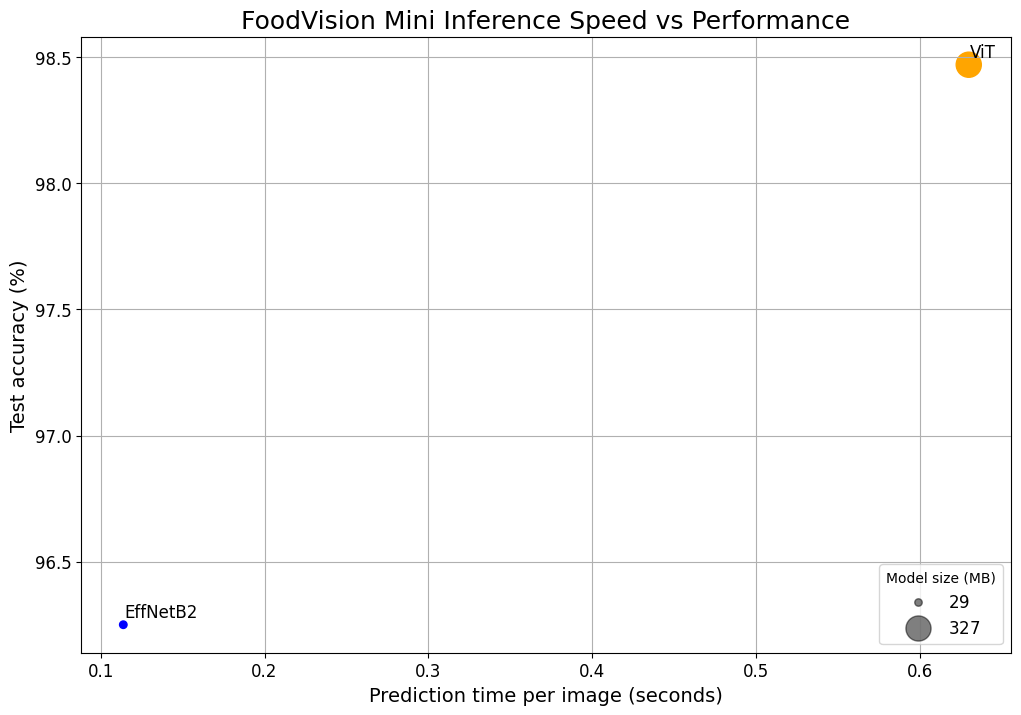

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
!mkdir images/
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

The plot really visualizes the speed vs. performance tradeoff, in other words, when you have a larger, better performing deep model (like our ViT model), it generally takes longer to perform inference (higher latency).

There are exceptions to the rule and new research is being published all the time to help make larger models perform faster.

And it can be tempting to just deploy the best performing model but it's also good to take into consideration where the model is going to be performing.

In our case, the differences between our model's performance levels (on the test loss and test accuracy) aren't too extreme.

But since we'd like to put an emphasis on speed to begin with, we're going to stick with deploying EffNetB2 since it's faster and has a much smaller footprint.

# 7. Brining FoodVision into life by creating a Gardio demo

As state above, there are many way we can bring our code to life, there are tons of them accross the internet with a simple google

So today we will be introducting to [Gradio](https://www.gradio.app/).

So why create a demo?

Numbers look nice, metrics look nice, but to appeal the general audience that use we need to deploy into something more friendlier for the people.

Let's start

In [ ]:
# Import/install Gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f"Gardion version: {gr.__version__}")

Gardion version: 5.42.0


## 7.1 Gradio overview

The overall premise of Gradio is with inputs and ouputs. So what are our **inputs** and **outputs**.

So our machine learning model does.

```
inputs -> ML model -> outputs
```
In our case for FoodVision Mini, our inputs is a bunch of pictures of food and the outputs are names of that food
```
images of food -> ML model -> class_names
```
Through the concepts of inputs and outputs, we can bridge to almost any other kind of ML problem.

There are serveral inputs and outputs but the import part is the ML model that you will build,

Gradio emulates this paradigm by creating an interface from inputs to outputs

```
gradio.Interface(fn, inputs, outputs)
```


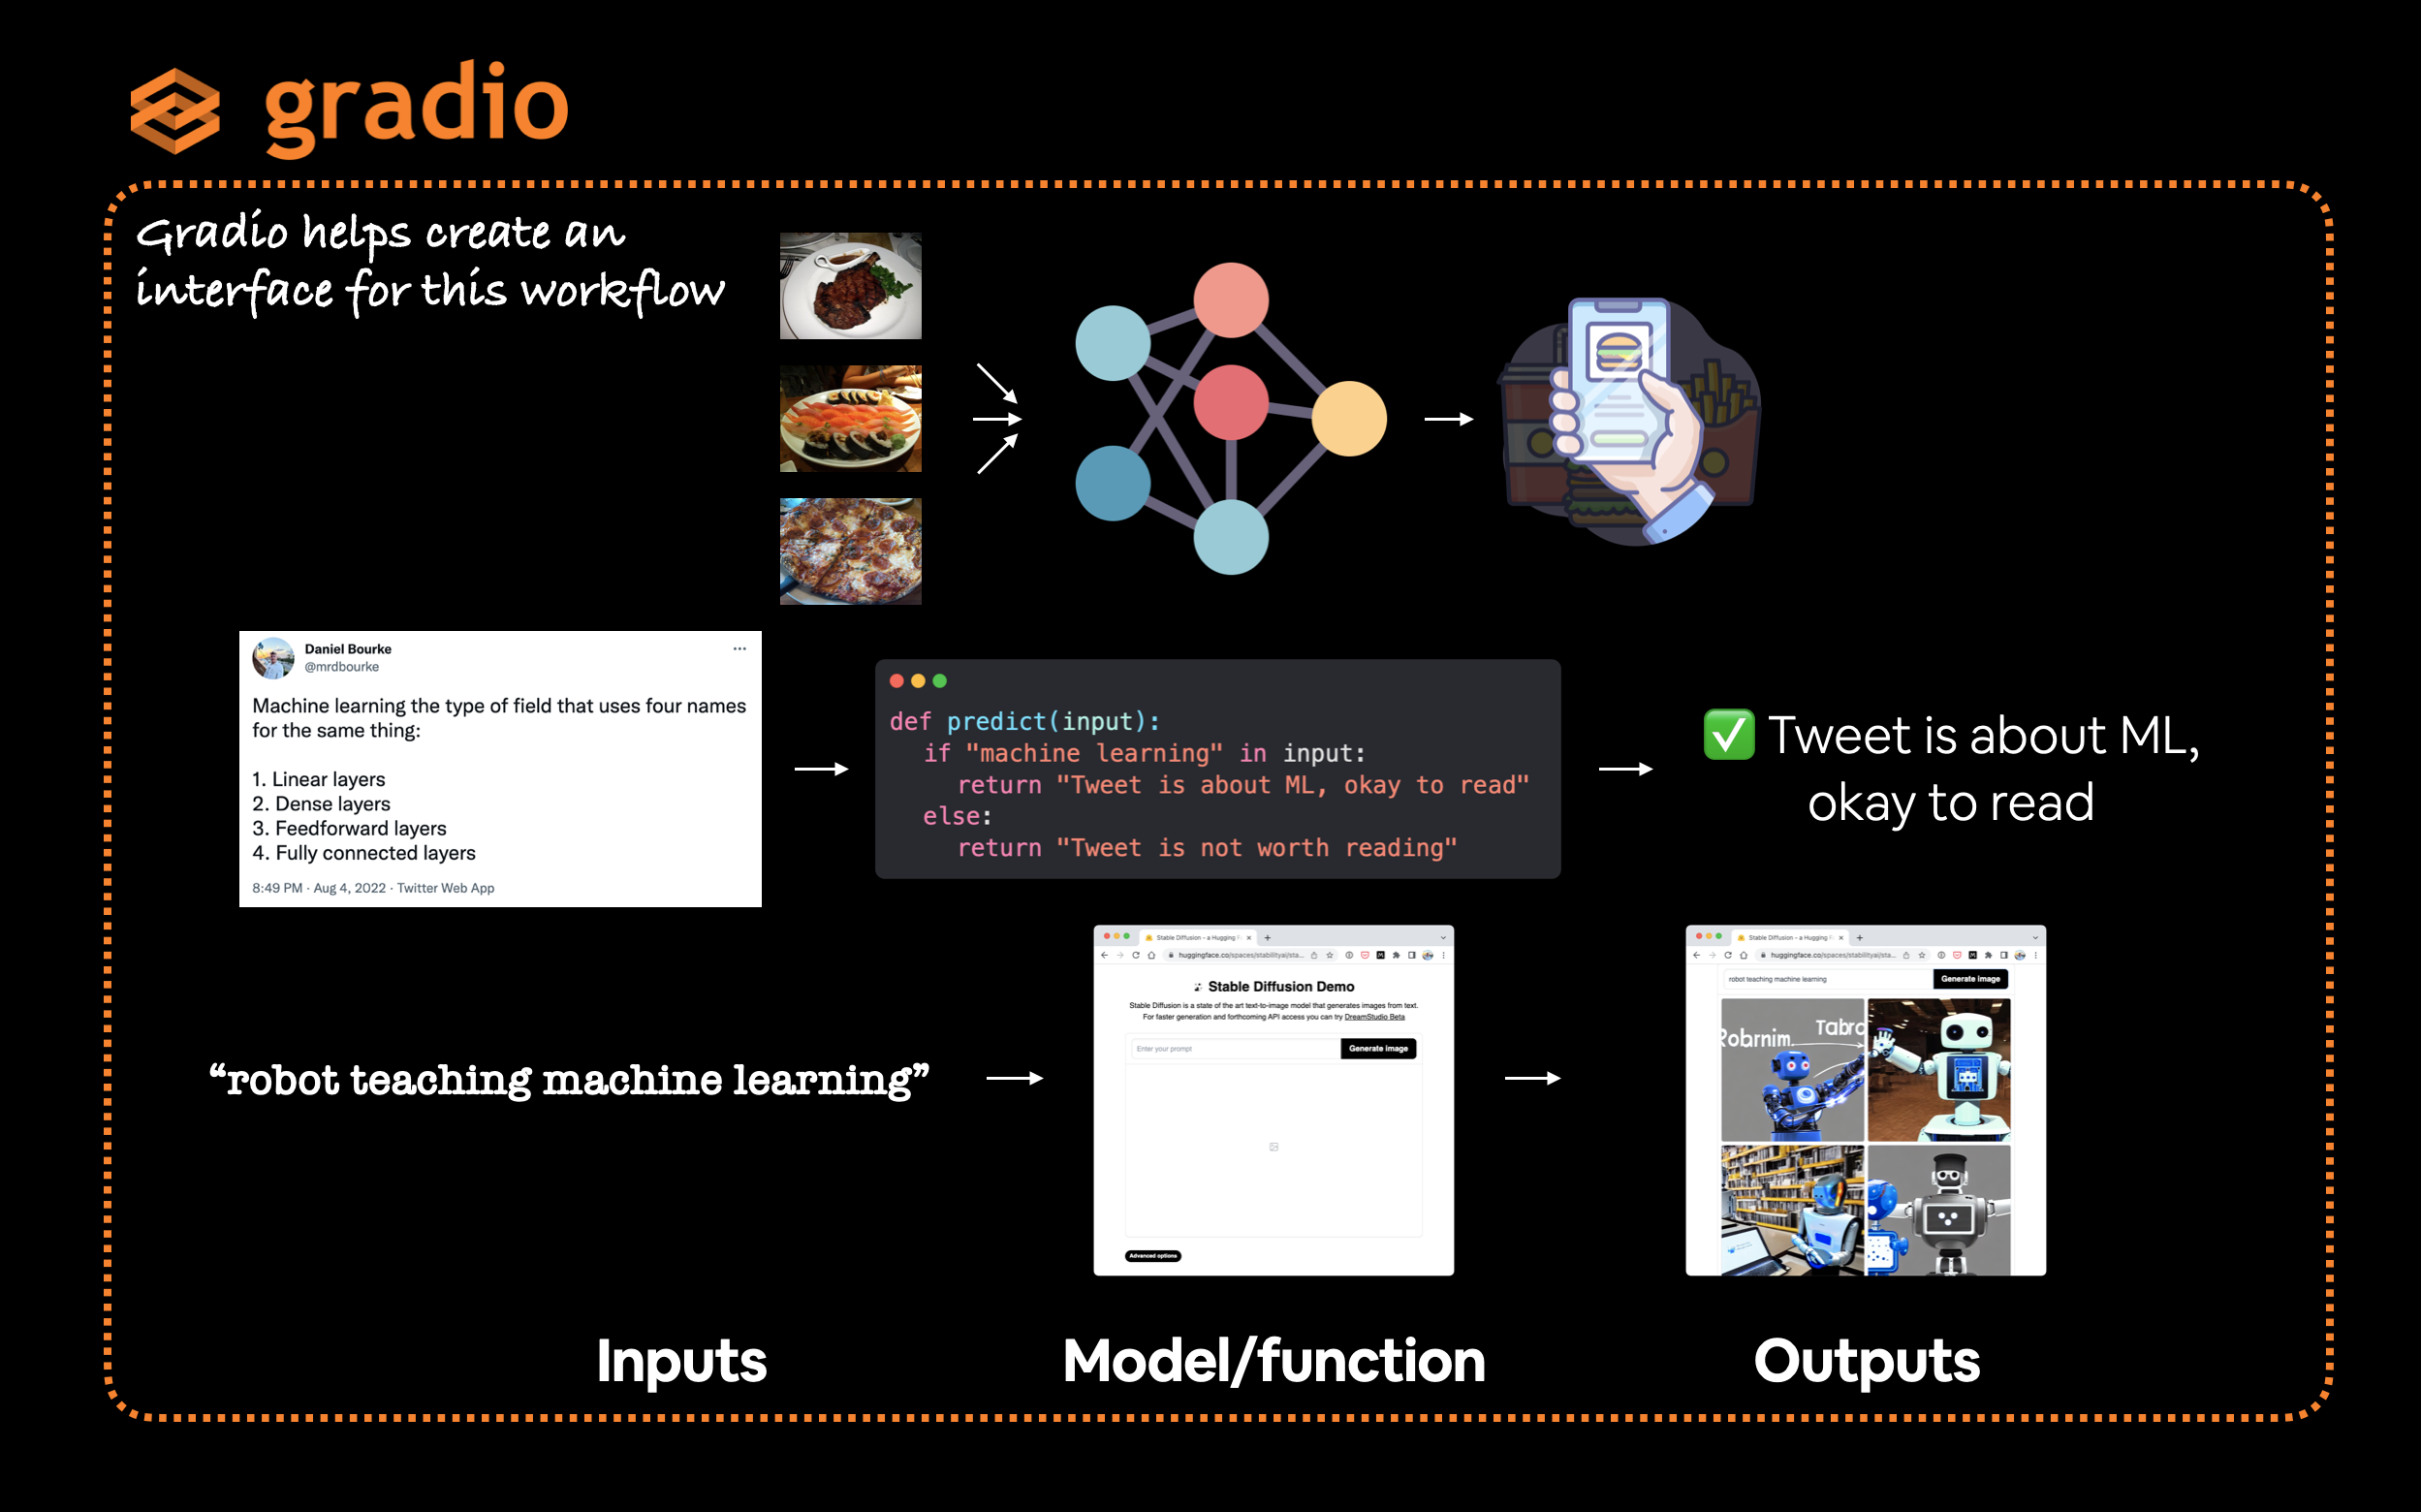

## 7.2 Creating a function to map our inputs and outputs

To create our FoodVision Mini with Gradiio, we'll need a function to map our inputs and outputs.

We  create a function earlier called `pred_and_store()` to make predictions with a given model accross a list of target flies and store them in a list of dict

We can just do the same but this time will be focusing on making prediction on a **single** image with our EffNetB2 model.effnetb2

More specifically, we want a function that takes an images as inpurt, preprocesses(transform) it and make prediction with EffNetB2 and return the prediction.and

In pseudocode:
```
input: images -> transform -> predicit with EffNetB2 -> output: pred, pred prob, time taken
```

We will be sticking with CPU for now

In [ ]:
# Putt EffNetB2 on CPU
effnetb2.to("cpu")
#Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
# function to replicated the workflow
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

Let's see if our function in action performing a prediction on random img

Start by getting a list of all image from the test directory and then randomly picking one of them

Then we'll open the randomly seleccted image with `PIL.Image.open()`

Finally apss it with `predict()` function

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/389730.jpg

Prediction label and probability dictionary: 
{'pizza': 0.0545542910695076, 'steak': 0.27325743436813354, 'sushi': 0.6721882224082947}
Prediction time: 0.16291 seconds


## 7.3 Creating a list of example images

Our `predict()` function enables us to go from inputs -> transform -> ML models -> output_size

that what we exactly need for our Gradio Image.DecompressionBombError

Let's create an examples list for our gradio demo



In [ ]:
example_list = [[str(filepath)]for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/3138001.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2549661.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2111981.jpg']]

## 7.4 Building a Gradio interface
Let's create a Gradio interface to replicated the workflow:

```
input: image -> transform -> predicit with EffNetB2 -> output: pred, pred prob, time taken
```

The following parameters with `gradio.Interface()
* `fn` - A python funciton to map `inputs` to `outputs`, in our case, we'll use our `predict()` function.
* `inputs` - the input to our interface
* `outputs` - the output of our interface, such as an image using `gradio.Image()`
  * Note: Gradio comes with many in-built for `inputs` and `outputs` options known as "Components"
* `examples` - a list of example to showcase for demo
* `title` a title for the demo
* `desription` - a description for the demo
* `article` - refrence note at the bottom of the demo



In [ ]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b27961a076823c13a5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 8. Turning our FoodVision Mini Gradio Demo into a deployable app

We just done a demo, now how can we make it public so everybody can use it?

We can do it permantly by upload it to [Hugging Face Space](https://huggingface.co/spaces/launch)

## 8.1 What is hugging face?

You can think of Hugging Face Space is a github for machine learning.
>Note: There are many other places we could upload and host our Gradio app such as, Google Cloud, AWS (Amazon Web Services) or other cloud vendors, however, we're going to use Hugging Face Spaces due to the ease of use and wide adoption by the machine learning community.

## 8.2 Deployed Gradio app struccture

To upload our demo Gradio app, we'll want to put everything relating to it into a single directory

For example:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Where:
* `09_pretrained_effnetb2_feature_extractor_piazza_steak_syshi_20_percent.pth` is our Pytorch model file
* `app.py` contain our Gradio app
  > Note that `app.py` is a default name for Hugging Face Space
* `example/` contains example iamges to use with our Gradio app
* `model.py` contains the model definition as well as
* `requirements.txt` contains the dependencies to run our app such as `torch`, `torchvision` and `gradio`



## 8.3 Ceating a `demos` folder to store out FoodVision Mini app files

To begin, let's first create a `demos/` directory to store all our FoodVision Mini app file.

We can do this with Python `pathlib.Path("path_to_dir")` to establish the directory path and  `pathlib.Path("path_to_dir").mkdir()` to create it

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
# If the file doesn't exist, create it anyway
foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

# Check what is in the folder
!ls demos/foodvision_mini

## 8.4 Creating a folder of examples images to use with our FoodVision Mini demo

We just got a directory to store our FoodVision mini demo files, let's add some examples to it
For now 3 would be enough
M

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


let's verify

In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list


[['examples/2582289.jpg'], ['examples/592799.jpg'], ['examples/3622237.jpg']]

Great!

## 8.5 Moving our trained EffNetB2

We previously save the EffNetB2 model ynder `models/...pth`. So let's move it intos `demos/foodvision_mini` directory.

To do that we can use `shutil.move()` method passing `src`(the source path of the target file) and `dst`(the destination path of the target file needed to be move)

In [ ]:
import shutil
from pathlib import Path

# Create a source path for our target model
effnetb2_source = Path("models/09_pretrained_effnetb2_feature_extractor.pth")

# Create a destination path for our target model
effnetb2_destination = foodvision_mini_demo_path / effnetb2_source.name
# try to move the file
try:
  print(f"[INFO] Moving {effnetb2_source} to {effnetb2_destination}")
  shutil.move(src=effnetb2_source, dst=effnetb2_destination)
  print(f"[INFO] Moving completed!")
except:
  print(f"[ERROR] Unable to move {effnetb2_source} to {effnetb2_destination}")
  print(f"[INFO] No model found at {effnetb2_source}")
  print(f"[INFO] Moving cancelled")
#

[INFO] Moving models/09_pretrained_effnetb2_feature_extractor.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor.pth
[INFO] Moving completed!


## 8.6 Turning the EffnetB2 model into a python script

Currently we have our EffNetB2 model save as .pth, and to load we can use `model.load_state_dict()` along with `torch.load`

But before that, firstly we need a way to instantiate a `model`

By turning into python script, we can  use it to create our EffNetB2 `model` instance as well as get appropriate trasnforms

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


## 8.7 Turning FoodVision Mini Gradio app into Python script

We now have a script of `model.py` as well as a path to saved model `state_dict` that we can load it

Now we consturt `app.py`, ***(we will use HuggingFace Spae default name `app.py` )***

Our `app.py` will have four main part.

1. **Import and class names setup** - Here we'll import various dependencies for our demo incl `create_effnetb2_model()` function from `model.py` as well as setup the different class names for our FoodVision mini app
2. **Model and transforms preparation** - Here we'll create an EffNetbb2 model instanes along with the transforms to go with it and we'll load the saved model weights/`state_dict`. We will also set the device as `cpu` in torch load so our model get laoded in CPU instead of GPU
3. **Predict funtion** - Gradio's `gradio.Interface()` take a `fn` parameter to map inputs to outputs, our `predict()` funciton will be the same as the one we defined above in section 7.2
  > Note: We'll have to create the example list on the fly via the examples parameter. We can do so by creating a list of the files inside the examples/ directory with: [["examples/" + example] for example in os.listdir("examples")].
4. **Gradio app** - This is where tha min logic of our demo will live


In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


## 8.8 Create a requirements file for Foodvision mini

To make sure the demo run without any errors we need to make sure our target machine meet the requirements.



In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


# 9 . Deploying FoodVision mini app to HuggingFace Space

There are two ways:
1. Uploading via the [HuggingFace Web interface(easiest)](https://huggingface.co/docs/hub/repositories-getting-started#adding-files-to-a-repository-web-ui)
2. Uploading via [command line or terminal](https://huggingface.co/docs/hub/repositories-getting-started#terminal)
> Bonus: You can also use the huggingface_hub library to interact with Hugging Face, this would be a good extension to the above two options.

## 9.1 downloading FoodVision Mini app file

First let's check what do we have in the filepath


In [ ]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor.pth  examples	requirements.txt
app.py					      model.py


Now let's compresed everything into a zipfile using command

To do so, we will using:
```
zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"
```

Where:
* `zip` stands for zipping folder
* `-r` stands for "recursive" as in, "go thorugh everything in the target folder"
* `.../foodvision_mini.zip` is the target folder
* * stand for "all the files in the current directory

Or we can also download the zipfile using
```
google.colab.files.download("demos/foodvision_mini.zip")
```

In [ ]:
# # Change into and then zip the foodvision_mini folder but exclude certain files
# !cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# # Download the zipped FoodVision Mini app (if running in Google Colab)
# try:
#     from google.colab import files
#     files.download("demos/foodvision_mini.zip")
# except:
#     print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

## 9.2 Run locally

Yea

## 9.3 Upload to Hugging Face Spaces

There are two primary ways to upload your FoodVision Mini app to Hugging Face Spaces:

1.  **Uploading via the Hugging Face Web Interface (Easiest):** This method involves using the drag-and-drop interface provided on the Hugging Face website. You can find more details [here](https://huggingface.co/docs/hub/repositories-getting-started#adding-files-to-a-repository-web-ui).

2.  **Uploading via Command Line or Terminal:** This method uses Git commands to push your files to the Hugging Face repository. You can find more details [here](https://huggingface.co/docs/hub/repositories-getting-started#terminal).

**Bonus:** You can also use the `huggingface_hub` Python library to interact with Hugging Face Spaces programmatically.

Here's a general workflow for uploading via the command line:

1.  **Sign up for a Hugging Face account.**
2.  **Create a new Hugging Face Space:** Go to your profile and click "New Space".
    *   Give your Space a name (e.g., `your_username/foodvision_mini`).
    *   Select a license (e.g., MIT).
    *   Select Gradio as the Space SDK.
    *   Choose whether your Space is public or private.
    *   Click "Create Space".
3.  **Clone the repo locally:** Run `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in your terminal.
4.  **Copy/move app files:** Move the contents of your local `foodvision_mini` folder into the cloned repository folder.
5.  **Install Git LFS (if needed):** For files larger than 10MB (like your PyTorch model file), you'll need Git Large File Storage. Install it and run `git lfs install`.
6.  **Track large files with Git LFS:** In the cloned repository directory, run `git lfs track "*.file_extension"` for any large files. For your model file, use `git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"`.
7.  **Add and commit files:**
    *   Add the `.gitattributes` file (created automatically when cloning from Hugging Face): `git add .gitattributes`
    *   Add the rest of your app files: `git add *`
    *   Commit your changes: `git commit -m "first commit"`
8.  **Push to Hugging Face:** `git push`
9.  **Wait for the build:** It may take a few minutes for the build to complete and your app to become live.

In [ ]:
# 1. Clone the repo locally
#!git clone https://huggingface.co/spaces/shyn1/FoodVision_Mini

In [ ]:
# 2. Copy and move the contents of the folder into clones repo folder
#!cp -r demos/foodvision_mini/* FoodVision_Mini

In [ ]:
#!git lfs install
#!git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

In [ ]:
# setup identities
#!git config --global user.email "shynarchie@gmail.com"
#!git config --global user.name "shyn1"

In [ ]:
# !cd /content/FoodVision_Mini
# !git add .gitattributes
# !git add *
# !git commit -m "first time upload"
# !git push

To authenticate with Hugging Face and push your changes, you'll need to provide your username and password or an access token.

Here's how you can do it:

1.  **Generate a Hugging Face Access Token:** Go to your Hugging Face settings ([https://huggingface.co/settings/tokens](https://huggingface.co/settings/tokens)) and create a new access token with write permissions.
2.  **Run the following cell:** This will prompt you to enter your Hugging Face username and the access token you just generated. Git will then store these credentials for future use.

Testing out save and load checkpoint

In [ ]:
## testing out save and load checkpoint

import torch

def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth.tar"):
    """Saves model and optimizer state during training."""
    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved to {filename}")

def load_checkpoint(filename, model, optimizer):
    """Loads model and optimizer state from a checkpoint."""
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        loss = checkpoint['loss']
        print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
        return start_epoch, loss
    else:
        print(f"No checkpoint found at '{filename}'")
        return 0, None

# Example usage within your training loop:

# Assuming you have your model, optimizer, train_dataloader, and test_dataloader defined

# Inside your training loop (e.g., after each epoch):
# save_checkpoint(effnetb2_food101, optimizer, epoch, training_loss)

# To resume training:
# start_epoch, last_loss = load_checkpoint("checkpoint.pth.tar", effnetb2_food101, optimizer)
# Then continue your training loop from start_epoch

# 10. Creating FoodVision big

We've create small, now we create big.

We go from 3 classes to 101 classes using Food101

The progress is still the same and the only different is num_classes

## 10.1 Creating a model and transforms for FoodVision big

We will be using EffNetB2 model because it was a good tradeoff between speed and perforamnace


In [ ]:
# Create EffnetB2 model capable of fitting to 101 classes to Food101
effnetb2_food101, effnetb2_food101_transforms = create_effnetb2_model(num_classes=101)

In [ ]:
from torchinfo import summary
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Nice Let's use data augmentation technique to alter the apperance of an input training sample.

By using `torchvision.transforms.TrivialAugmentWide()`

In [ ]:
# Create Food101 training data transforms
foodvision_train_transforms = torchvision.transforms.Compose([
  torchvision.transforms.TrivialAugmentWide(),
  effnetb2_food101_transforms
])

In [ ]:
#Check out input and output
print(f"Training transformation(Input):\n{foodvision_train_transforms}\n")
print(f"Output transformation(Output):\n{effnetb2_food101_transforms}")

Training transformation(Input):
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Output transformation(Output):
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


## 10.2 Getting Data for FoodVision Big
since it is Food101 it will be big

In [ ]:
from torchvision import datasets
from pathlib import Path
data_dir = Path("data")

train_data = datasets.Food101(
    root=data_dir,
    split="train",
    download=True,
    transform=foodvision_train_transforms
)
test_data = datasets.Food101(
    root=data_dir,
    split="test",
    download=True,
    transform=effnetb2_food101_transforms
)

100%|██████████| 5.00G/5.00G [04:15<00:00, 19.5MB/s]


In [ ]:
# Get a liss of claas name
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## 10.3 Creating a subset for Food101

For training and studying purposes, we will be using only 20% of the data, our goals is to beat +55% acc

First, make a funciton to split the datasetes

In [ ]:
# Split function
def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [ ]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

## 10.4 tURNING FOOD101 datastes into `DataLoader`'s

In [ ]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

## 10.5 Training FoodVision BiG Model





Let's go, got everything ready.

We will use Adam optimzier with the learning rate of `1e-3` and `nn.CrossEntropyLoss` function

But since we got so many classes, we will have to smooth it down using `label_smoothing=0.1`

---
**What is label_smoothing**?

Label smoothing is a regularization technique (regularization is another word to describe the process of preventing overfitting) that reduces the value a model gives to anyone label and spreads it across the other labels.

For example(out of 5 classes):
model w/o label smoothing(output):
```
[0, 0, 0.99, 0.01, 0]
```
model w label smoothing(output):
```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

The model is still confident on its prediction of class 3 but giving small values to the other labels forces the model to at least consider other options.

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810


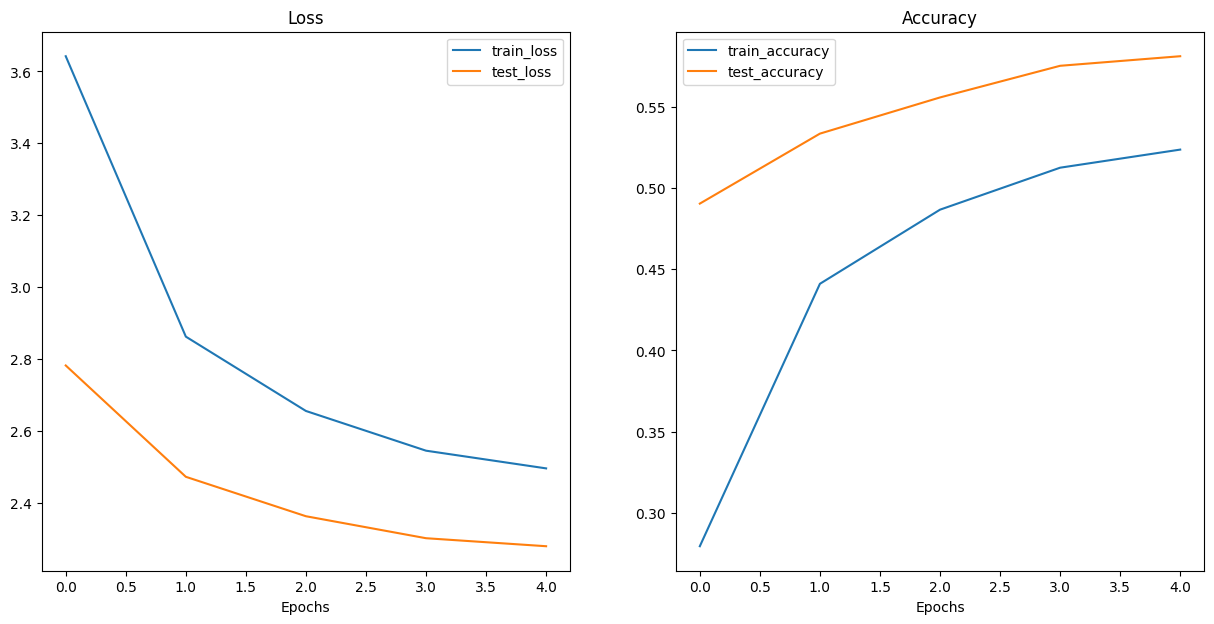

In [ ]:
# Check loss curve
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)


## 10.7 Saving and loading FoodVision Big

Since this is big model and take a lot of time, make sure we save and can be load it later



In [ ]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [ ]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

## 10.8 Check for the size
Let's see what is the size after trained

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")


Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


Itt stay at very low despite of how long it took and how big the datasets is

# 11. Turn FoodVision into a deployable app

Wewill still be using gardio

To begiin let's crate a directory to save all the nessesary files, our strucutre folder would look something like this:m
```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [ ]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

## 11.2 Saving Food101 Class names to (class_names.txt)

In [ ]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


Excellent, now let's make sure we can read them in.

To do so we'll use Python's `open()` in read mode ("r") and then use the `readlines()` method to read each line of our class_names.txt file.

And we can save the class names to a list by stripping the newline value of each of them with a list comprehension and `strip().`

In [ ]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2025-08-15 18:35:17--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.03s   

2025-08-15 18:35:17 (105 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



Lastly we need to make model into the script

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big/model.py


## 11.4 This is it, turning foodvision big gardip app into python script

we got model.py now we need app.py for huggingface space

In [ ]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


## 11.5 Create a requirements file for FoodVision Big

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4


Writing demos/foodvision_big/requirements.txt


Using the terminal we will be deploy it into huggingface space


In [ ]:
!git config --global credential.helper store
!git push

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Change into the cloned repository directory
# Replace "FoodVision_Mini" with the actual name of your cloned repository directory
%cd /content/Food101_20/

# Add all files to the staging area
!git add .

# Commit the changes
!git commit -m "Add FoodVision Big app files"

# Push the changes to the Hugging Face repository
!git push

/content/Food101_20
On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
fatal: Authentication failed for 'https://huggingface.com/'


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!git lfs install
!git lfs track "*.jpg"
# You might also need to track your model file if it's large
# !git lfs track "*.pth"

Updated git hooks.
Git LFS initialized.
Tracking "*.jpg"


In [ ]:
# Change into the cloned repository directory (if you are not already there)
# Replace "Food101_20" with the actual name of your cloned repository directory
%cd /content/Food101_20/

# Add the .gitattributes file to the staging area
!git add .gitattributes

# Add the rest of your app files (including the images now tracked by LFS)
!git add .

# Commit your changes
!git commit -m "Add FoodVision Big app files and configure Git LFS"

# Push the changes to the Hugging Face repository
!git push

/content/Food101_20
[main 19b3ae9] Add FoodVision Big app files and configure Git LFS
 1 file changed, 1 insertion(+)
Uploading LFS objects: 100% (1/1), 32 MB | 0 B/s, done.
Enumerating objects: 17, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 2 threads
Compressing objects: 100% (13/13), done.
Writing objects: 100% (15/15), 2.74 MiB | 5.23 MiB/s, done.
Total 15 (delta 4), reused 0 (delta 0), pack-reused 0
remote: -------------------------------------------------------------------------
remote: Your push was rejected because it contains binary files.
remote: Please use https://git-lfs.github.com/ to store binary files.
remote: See also: https://hf.co/docs/hub/repositories-getting-started#terminal
remote: 
remote: Offending files:
remote:   - examples/04-pizza-dad.jpg (ref: refs/heads/main)
remote: -------------------------------------------------------------------------
To https://huggingface.co/spaces/shyn1/Food101_20
 ! [remote rejected] main -> main (pre-

In [ ]:
# Change into the cloned repository directory (if you are not already there)
# Replace "Food101_20" with the actual name of your cloned repository directory
%cd /content/Food101_20/

# Delete the offending file
!rm examples/04-pizza-dad.jpg

/content/Food101_20
rm: cannot remove 'examples/04-pizza-dad.jpg': No such file or directory


In [ ]:
%%writefile /content/demos/foodvision_big/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==4.37.2

Overwriting /content/demos/foodvision_big/requirements.txt


In [ ]:
%pip install "numpy<2"